# Triplet Loss Pre-training

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import numpy as np
import pandas as pd
from tqdm import tqdm
import tensorflow as tf
import io

import matplotlib.pyplot as plt
from ipywidgets import interact

import tensorflow_addons as tfa
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import *
from tensorflow.keras.applications import ResNet50V2

from tensorflow_addons.losses import TripletSemiHardLoss, TripletHardLoss

from datetime import datetime

from beeid.utils import sensitivity_map

from beeid2.models import simple_cnnv2
from beeid2.data_utils import load_tf_dataset, prepare_for_triplet_loss
from beeid2.viz import show_sensitivity_maps
from beeid2.evaluation import cmc_evaluation, plot_cmc
from beeid2.evaluation import get_interactive_plot_query_gallery


### Prepare dataset

Select the dates for Training, Validation and Testing datasets.

In [2]:
df=pd.read_csv("../../data/untagged_dataset.csv")

In [3]:
df

,Unnamed: 0,track_id,frame,angle,x,y,parts_num,tag_id,virtual,pollen_score,...,tailx,taily,closest_bee,num_bees_frame,filename,video_name,abdomen_size,abdomen_angle,global_track_id,label
0,0,5235,11196,193.240520,1444,508,4,NaN,False,0.0,...,1384.0,284.0,714.154045,6,/mnt/storage/work/jchan/untagged_bees/images/2...,28_02_R_190720080000,231.896529,284.995079,28_02_R_190720080000_5235,1787
1,1,2147,5760,180.000000,1696,672,4,NaN,False,0.0,...,1688.0,440.0,325.379778,13,/mnt/storage/work/jchan/untagged_bees/images/9...,9_02_R_190719130000,232.137890,271.974934,9_02_R_190719130000_2147,3110
2,2,1928,7780,180.000000,824,960,4,NaN,False,0.0,...,800.0,724.0,452.901755,8,/mnt/storage/work/jchan/untagged_bees/images/1...,12_02_R_190723160000,237.217200,275.806727,12_02_R_190723160000_1928,3930
3,3,597,2858,153.434949,1060,860,4,NaN,False,0.0,...,1060.0,628.0,388.741559,4,/mnt/storage/work/jchan/untagged_bees/images/3...,34_02_R_190720140000,232.000000,270.000000,34_02_R_190720140000_597,120
4,4,1225,3934,123.111342,628,964,4,NaN,False,0.0,...,808.0,800.0,664.590099,4,/mnt/storage/work/jchan/untagged_bees/images/9...,9_02_R_190717130000,243.507700,222.336999,9_02_R_190717130000_1225,3946
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109649,109649,1626,5922,137.290610,504,672,4,NaN,False,0.0,...,644.0,448.0,819.180078,5,/mnt/storage/work/jchan/untagged_bees/images/6...,62_02_R_190728140000,264.151472,237.994617,62_02_R_190728140000_1626,3024
109650,109650,1323,3018,174.957549,1244,600,4,NaN,False,0.0,...,1240.0,348.0,448.035713,5,/mnt/storage/work/jchan/untagged_bees/images/1...,13_02_R_190722170000,252.031744,270.909380,13_02_R_190722170000_1323,407
109651,109651,4854,11628,182.121096,672,632,4,NaN,False,0.0,...,700.0,392.0,602.288967,8,/mnt/storage/work/jchan/untagged_bees/images/6...,6_02_R_190724100000,241.627813,263.345575,6_02_R_190724100000_4854,4289
109652,109652,56,1614,213.690068,1312,468,4,NaN,False,0.0,...,1148.0,280.0,677.465866,6,/mnt/storage/work/jchan/untagged_bees/images/3...,35_02_R_190720150000,249.479458,311.099506,35_02_R_190720150000_56,2448


In [4]:
labels = df.label.unique()
train_num = int(len(labels)*0.8)
rand_labels = np.random.permutation(len(labels))
train_labels = rand_labels[:train_num]

In [5]:
train_df = df[df.label.isin(train_labels)]
valid_df = df[~df.label.isin(train_labels)]

train_df = prepare_for_triplet_loss(train_df)
valid_df = prepare_for_triplet_loss(valid_df)

### Tensorflow Dataset

In [6]:
train_dataset = load_tf_dataset(train_df, rescale_factor=4, augmentation=False, label_column="label")
valid_dataset = load_tf_dataset(valid_df, rescale_factor=4, label_column="label")

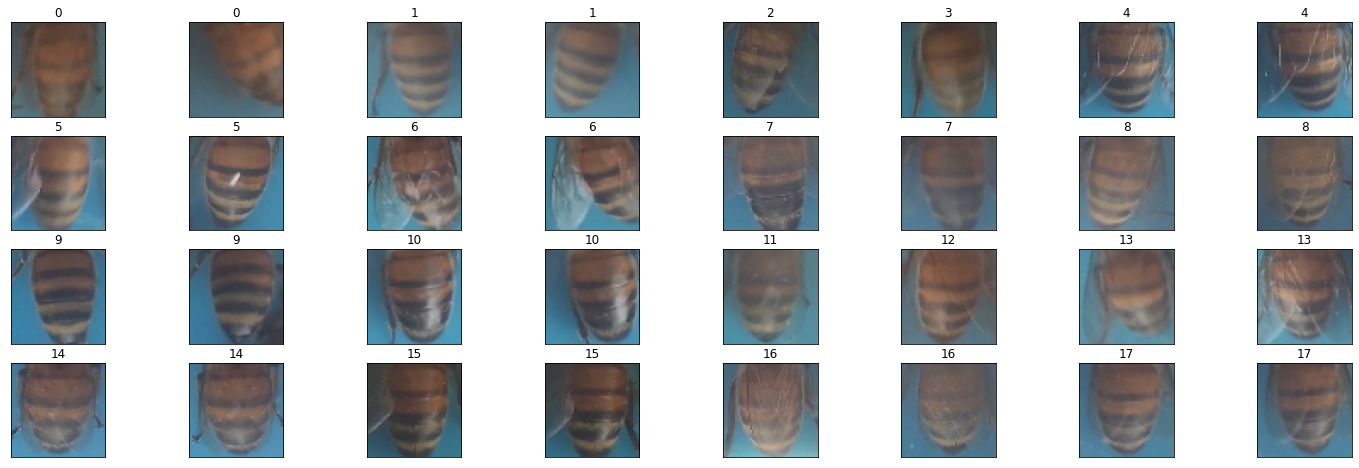

In [7]:
data = train_dataset.batch(32)
gen = iter(data)
sample_batch = next(gen)

EXAMPLES=2

fig, ax = plt.subplots(4, 8, figsize=(25, 8))
ax = ax.ravel()
for j in range(32):
    ax[j].imshow(sample_batch[0][j])
    ax[j].set_title("{}".format(sample_batch[1][j].numpy()))
    ax[j].set_xticks([])
    ax[j].set_yticks([])

### Model

In [8]:
# model = simple_cnnv2(input_shape=(56, 56, 3), conv_blocks=3, latent_dim=128)

In [9]:
# model.summary()

In [10]:
def log_normal_pdf(sample, mean, logvar, raxis=1):
        log2pi = tf.math.log(2. * np.pi)
        return tf.reduce_sum(-.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),axis=raxis)
    
class CVAE(tf.keras.Model):
    """Convolutional variational autoencoder."""
    def __init__(self, latent_dim):
        super(CVAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = simple_cnnv2(input_shape=(56, 56, 3), conv_blocks=3, latent_dim=latent_dim*4, l2_norm=False)

        self.decoder = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape=(latent_dim*2,)),
                tf.keras.layers.Dense(units=7*7*32, activation=tf.nn.relu),
                tf.keras.layers.Reshape(target_shape=(7, 7, 32)),
                tf.keras.layers.Conv2DTranspose(
                    filters=64, kernel_size=3, strides=2, padding='same',
                    activation='relu'),
                tf.keras.layers.Conv2DTranspose(
                    filters=32, kernel_size=3, strides=2, padding='same',
                    activation='relu'),
                tf.keras.layers.Conv2DTranspose(
                    filters=32, kernel_size=3, strides=2, padding='same',
                    activation='relu'),
                # No activation
                tf.keras.layers.Conv2DTranspose(
                    filters=3, kernel_size=3, strides=1, padding='same'),
            ]
        )



    @tf.function
    def sample(self, eps=None):
        if eps is None:
            eps = tf.random.normal(shape=(100, self.latent_dim*2))
        return self.decode(eps, apply_sigmoid=True)

    def encode(self, x, l2_norm=False):
        mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        if l2_norm:
            mean = tf.math.l2_normalize(mean, axis=1)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=tf.shape(mean))
        return eps * tf.exp(logvar * .5) + mean

    def decode(self, z, apply_sigmoid=False):
        logits = self.decoder(z)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs
        return logits
    

    @tf.function
    def train_step(self, data):
        """Executes one training step and returns the loss.

        This function computes the loss and gradients, and uses the latter to
        update the model's parameters.
        """
        with tf.GradientTape() as tape:
            x, y_true = data
            mean, logvar = self.encode(x, l2_norm=False)
            z = self.reparameterize(mean, logvar)
            x_logit = self.decode(z)
            elbo = self.compute_elbo(x, x_logit, z, mean, logvar)
            disc_features, gen_features = tf.split(mean, num_or_size_splits=2, axis=1)
            triplet_loss = tfa.losses.triplet_semihard_loss(y_true, tf.math.l2_normalize(disc_features, axis=1), margin=0.20)
            loss = elbo + 50000 * triplet_loss
            
            
        gradients = tape.gradient(loss, self.trainable_variables)
        
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        self.compiled_metrics.update_state(x, x_logit)
        return {"loss": loss, "elbo": elbo, "triplet_loss": triplet_loss}
    
    def compute_elbo(self, x, x_logit, z, mean, logvar):
        cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
        logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
        logpz = log_normal_pdf(z, 0., 0.)
        logqz_x = log_normal_pdf(z, mean, logvar)
        elbo = -tf.reduce_mean(logpx_z + logpz - logqz_x)
        return elbo
        
    
    
    @tf.function
    def test_step(self, data):
        """Executes one training step and returns the loss.

        This function computes the loss and gradients, and uses the latter to
        update the model's parameters.
        """
        x, y_true = data
        mean, logvar = self.encode(x)
        z = self.reparameterize(mean, logvar)
        x_logit = self.decode(z)
        elbo = self.compute_elbo(x, x_logit, z, mean, logvar)
        disc_features, gen_features = tf.split(mean, num_or_size_splits=2, axis=1)
        triplet_loss = tfa.losses.triplet_semihard_loss(y_true, disc_features, margin=0.20)
        loss = elbo + 10000 * triplet_loss
        
        self.compiled_metrics.update_state(x, x_logit)
        return {"loss": loss, "elbo": elbo, "triplet_loss": triplet_loss}

In [11]:
model = CVAE(128)

In [12]:
# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(0.001))

In [13]:
data = valid_dataset.batch(32)
gen = iter(data)
valid_images = next(gen)

logdir = "../../logs_vae/" + datetime.now().strftime("%Y%m%d-%H%M%S")
# Define the basic TensorBoard callback.
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
file_writer_ir = tf.summary.create_file_writer(logdir + '/ir')

def show_reconstructions(epoch, logs):
    mean, logvar = model.encode(valid_images[0])
    z = model.reparameterize(mean, logvar)
    x_recon = model.decode(z, apply_sigmoid=True)
    
    figure = plot_reconstructions(x_recon)
    ir_image = plot_to_image(figure)
    
    with file_writer_ir.as_default():
        tf.summary.image("Confusion Matrix", ir_image, step=epoch)
    
    
def plot_reconstructions(images):
    fig, ax = plt.subplots(4, 8, figsize=(25, 8))
    ax = ax.ravel()
    for j in range(32):
        ax[j].imshow(images[j])
        ax[j].set_xticks([])
        ax[j].set_yticks([])
    plt.tight_layout()
    return fig

def plot_to_image(figure):
    """Converts the matplotlib plot specified by 'figure' to a PNG image and
    returns it. The supplied figure is closed and inaccessible after this call."""
    # Save the plot to a PNG in memory.
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    # Closing the figure prevents it from being displayed directly inside
    # the notebook.
    plt.close(figure)
    buf.seek(0)
    # Convert PNG buffer to TF image
    image = tf.image.decode_png(buf.getvalue(), channels=4)
    # Add the batch dimension
    image = tf.expand_dims(image, 0)
    return image
    

ir_callback = tf.keras.callbacks.LambdaCallback(on_epoch_end=show_reconstructions)

In [ ]:
# Train the network
BATCH_SIZE=256
EPOCHS=1000
PATIENCE=100

earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=PATIENCE, restore_best_weights=True)

history = model.fit(train_dataset.batch(BATCH_SIZE), validation_data=valid_dataset.batch(BATCH_SIZE), epochs=EPOCHS, callbacks=[earlystop, ir_callback, tensorboard_callback])


Epoch 1/1000
  1/344 [..............................] - ETA: 0s - loss: 16173.2051 - elbo: 6522.0210 - triplet_loss: 0.1930WARNING:tensorflow:From /home/jchan/anaconda3/envs/bees/lib/python3.7/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
344/344 [==============================] - 126s 368ms/step - loss: 11879.0678 - elbo: 6283.9525 - triplet_loss: 0.1119 - val_loss: 6820.6382 - val_elbo: 6244.9229 - val_triplet_loss: 0.0576
Epoch 2/1000
344/344 [==============================] - 133s 386ms/step - loss: 10147.1757 - elbo: 6255.9887 - triplet_loss: 0.0778 - val_loss: 6653.3359 - val_elbo: 6272.5879 - val_triplet_loss: 0.0381
Epoch 3/1000
344/344 [==============================] - 136s 396ms/step - loss: 9466.4165 - elbo: 6252.9612 - triplet_loss: 0.0643 - val_loss: 6592.7725 - val_elbo: 6258.6914 - val_trip

In [46]:
x_logit.shape

TensorShape([32, 56, 56, 3])

In [10]:
# model.save("models/pretraining_triplet_loss_no_augematation.tf")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: models/pretraining_triplet_loss_no_augematation.tf/assets


### Checking Training

In [1]:
train_df=pd.read_csv("data/train.csv")
test_df=pd.read_csv("data/test.csv")
valid_df=pd.read_csv("data/valid.csv")

len(train_df), len(valid_df), len(test_df)

NameError: name 'pd' is not defined

In [2]:
pd.DataFrame(history.history).plot()

NameError: name 'pd' is not defined

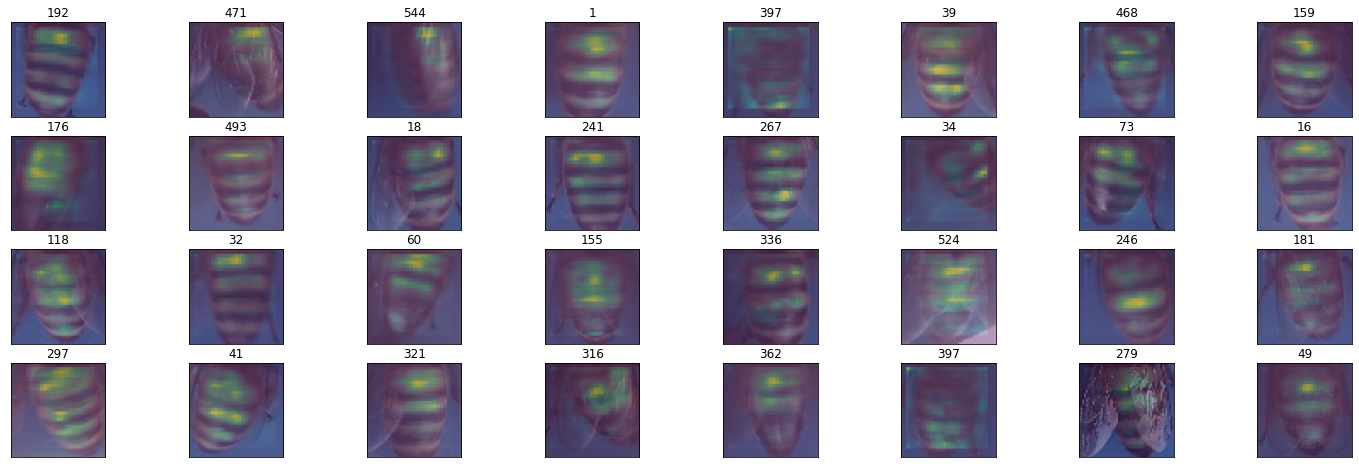

In [13]:
show_sensitivity_maps(model, valid_dataset)

#### Save model

In [14]:
# model.save("models/triplet_loss.tf")

## Evaluation

In [15]:
ITERATIONS=100
GALLERY_SIZE=10

### Evaluation only ids shared with the training set (validation set)

100%|██████████| 100/100 [01:34<00:00,  1.06it/s]


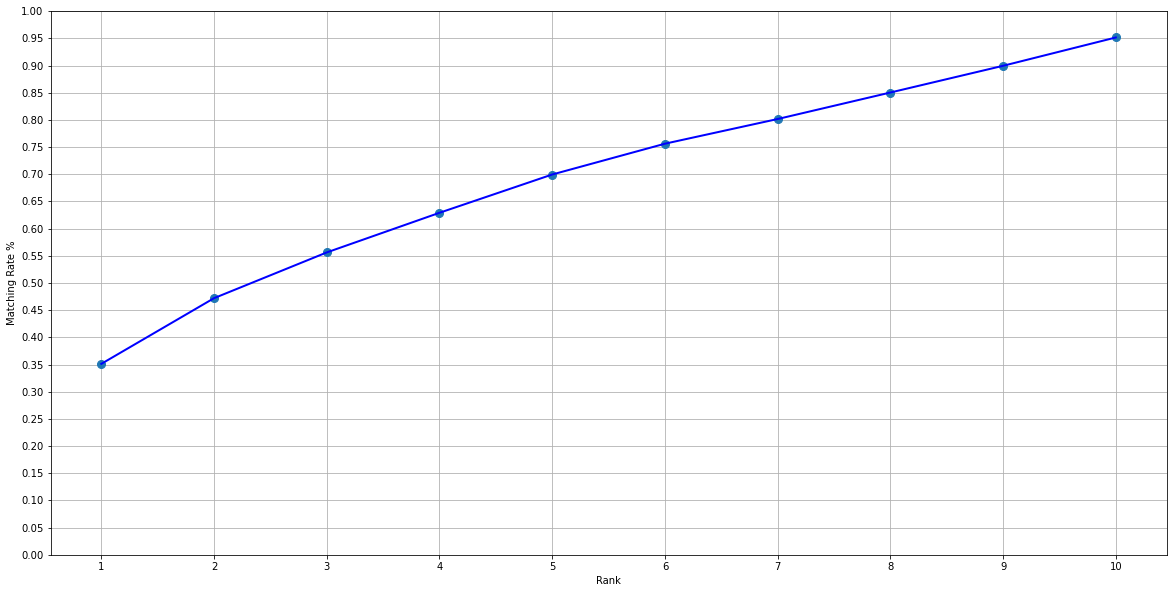

In [16]:
train_ids = train_df.track_tag_id.unique()

valid_with_shared_ids = valid_df[valid_df.track_tag_id.isin(train_ids)]

valid_with_shared_ids_ranks_means = cmc_evaluation(model, valid_with_shared_ids, iterations=ITERATIONS, gallery_size=GALLERY_SIZE)

plot_cmc(valid_with_shared_ids_ranks_means )

### Evaluation on the whole validation set

100%|██████████| 100/100 [03:42<00:00,  2.23s/it]


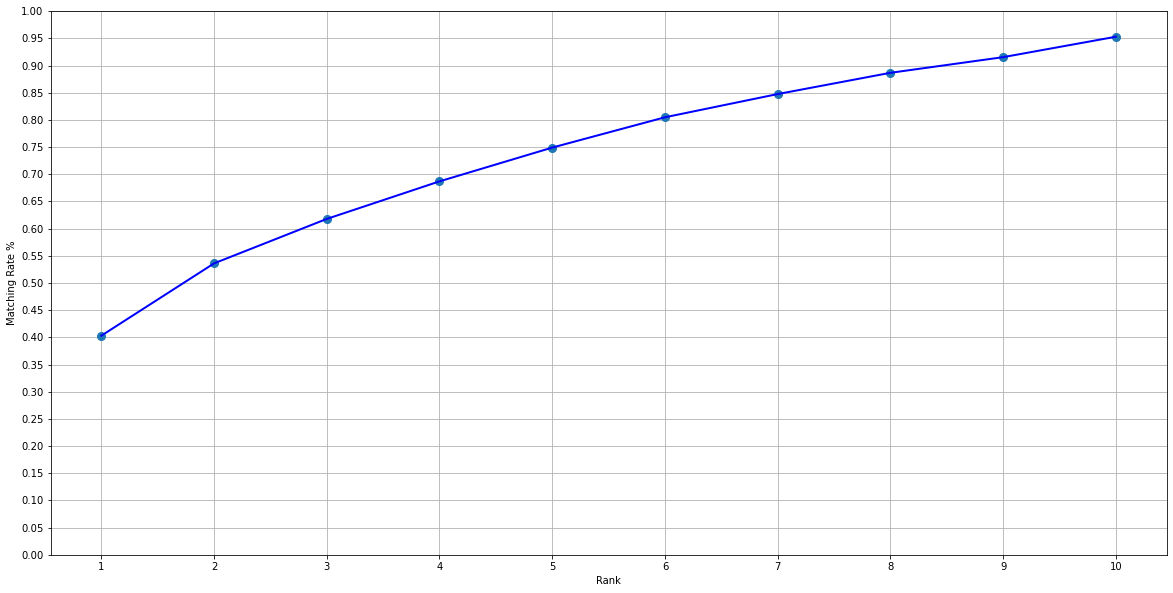

In [17]:
valid_ranks_means = cmc_evaluation(model, valid_df, iterations=ITERATIONS, gallery_size=GALLERY_SIZE)

plot_cmc(valid_ranks_means)

### Evaluation on whole test set

100%|██████████| 100/100 [13:03<00:00,  7.84s/it]


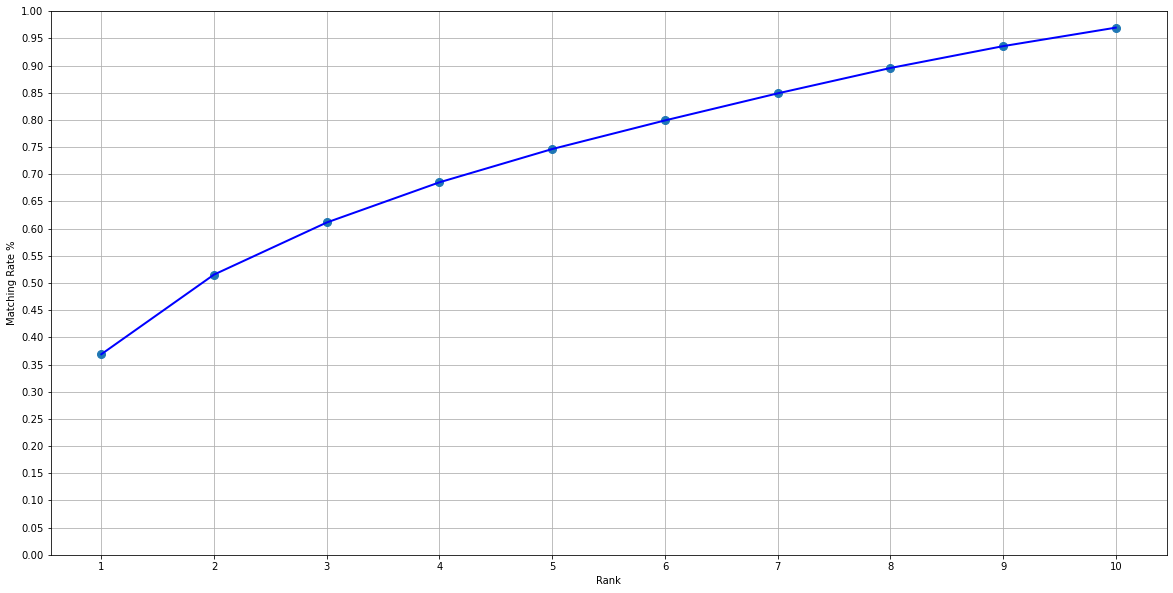

In [18]:
test_ranks_means = cmc_evaluation(model, test_df, iterations=ITERATIONS, gallery_size=GALLERY_SIZE)

plot_cmc(test_ranks_means)

In [19]:
train_ids = train_df.track_tag_id.unique()
test_ids = test_df.track_tag_id.unique()


intersection = set(train_ids) & set(test_ids)

print("Test set has {} Ids.".format(len(test_ids)))
print("Intersection of train and test set {}".format(len(intersection)))

Test set has 126 Ids.
Intersection of train and test set 29


100%|██████████| 100/100 [08:08<00:00,  4.88s/it]


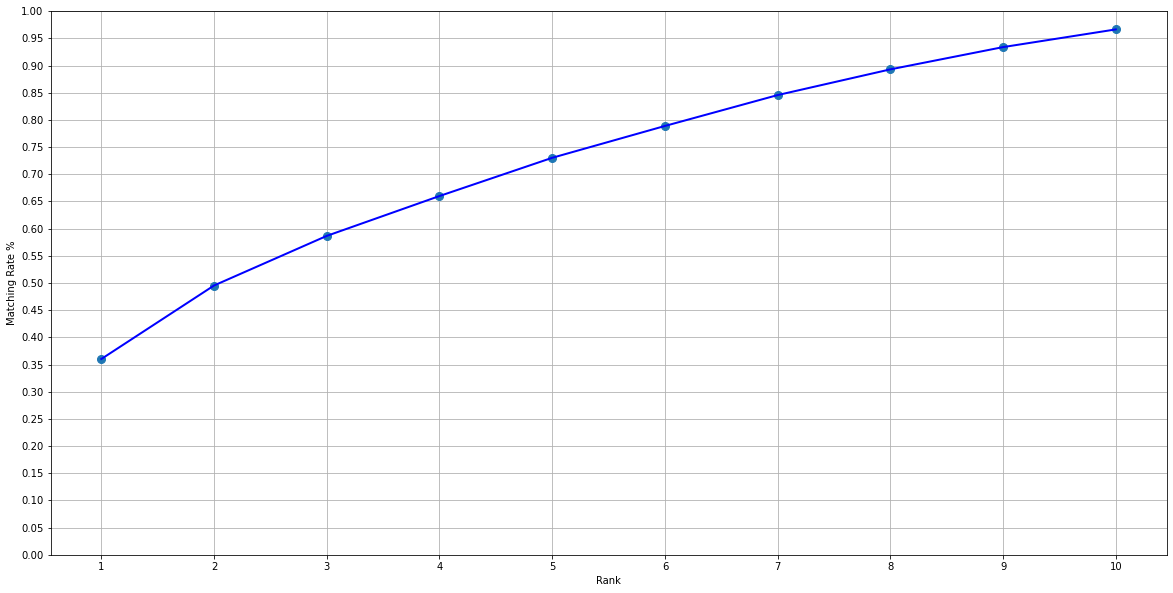

In [20]:
test_disjoint_train = test_df[~test_df.track_tag_id.isin(train_ids)]

test_disjoint_train_ranks_means = cmc_evaluation(model, test_disjoint_train, iterations=ITERATIONS, gallery_size=GALLERY_SIZE)

plot_cmc(test_disjoint_train_ranks_means)

#### Saving results

In [21]:
metric_dict = dict()

metric_dict["valid_cmc_only_train_ids"] = valid_with_shared_ids_ranks_means 
metric_dict["valid_cmc"] = valid_ranks_means
metric_dict["test_cmc"] = test_ranks_means
metric_dict["test_cmc_no_ids_overlap"] = test_disjoint_train_ranks_means

metric_df = pd.DataFrame(metric_dict)
metric_df.to_csv("results/pretraining_triplet_loss_no_augematation.csv")

#### Interactive Query Plotting

In [17]:
get_interactive_plot_query_gallery(model, valid_df)

interactive(children=(IntSlider(value=17, description='query_id', max=34), Checkbox(value=False, description='…